In [4]:
from itertools import product

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
MATURATION_TIME = 31*3

In [8]:
def weibull_growth_curve(t, ul, alpha, beta):
    return ul * (1 - np.exp(-(t/alpha)**beta))

def sample_growth_curve_data(n_obs: int, ul: float = 1.0, alpha: float = 20.0, beta: float = 1.0):
    #ts = np.arange(n_obs) + np.random.uniform(low=-0.4, high=0.4, size=n_obs)
    dts = np.random.uniform(0.0, 1.0, size=n_obs)
    ts = n_obs * np.cumsum(dts) / np.sum(dts)
    ys = weibull_growth_curve(ts, ul, alpha, beta)
    return ys

def sample_random_growth_curve_data(n_obs: int):
    ul = np.random.normal(loc=100.0, scale=10.0)
    alpha = np.random.normal(loc=30.0, scale=5.0)
    beta = np.random.normal(loc=1.5, scale=0.5)
    return sample_growth_curve_data(n_obs, ul, alpha, beta)

def sample_random_group_data():
    n_obs = np.random.randint(5.0, 100.0)
    return n_obs, sample_random_growth_curve_data(n_obs)

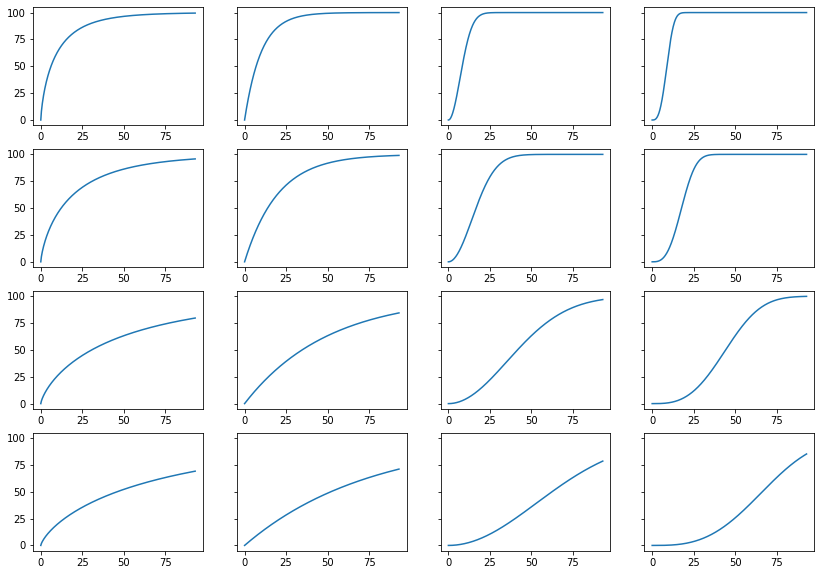

In [12]:
fig, axs = plt.subplots(4, 4, figsize=(14, 10), sharey=True)

alphas = [10.0, 20.0, 50.0, 75.0]
betas = [0.75, 1.0, 2.0, 3.0]

x = np.linspace(0, MATURATION_TIME, num=500)

for ax, (alpha, beta) in zip(axs.flatten(), product(alphas, betas)):
    y = weibull_growth_curve(x, 100.0, alpha, beta)
    ax.plot(x, y)

In [133]:
class FraudForcastingDataSimulator:
    
    def __init__(
        self,
        n_obs_min: int = 5,
        n_obs_max: int = 100,
        ultimate_loss_mean: float = 100.0,
        ultimate_loss_std: float = 10.0,
        alpha_mean: float = 30.0,
        alpha_std: float = 5.0,
        beta_mean: float = 1.5,
        beta_std: float = 0.5
    ):
        self.n_obs_min = n_obs_min
        self.n_obs_max = n_obs_max
        self.ultimate_loss_mean = ultimate_loss_mean
        self.ultimate_loss_std = ultimate_loss_std
        self.alpha_mean = alpha_mean
        self.alpha_std = alpha_std
        self.beta_mean = beta_mean
        self.beta_std = beta_std
    
    def simulate_multiple_groups(self, n_groups: int) -> pd.DataFrame:
        groups = []
        for group_id in range(n_groups):
            group = self.simulate_one_random_group()
            group['id'] = group_id
            groups.append(group)
        return pd.concat(groups).reset_index(drop=True)
    
    def simulate_one_random_group(self) -> pd.DataFrame:
        n_obs = np.random.randint(self.n_obs_min, self.n_obs_max)
        ul = np.random.normal(loc=self.ultimate_loss_mean, scale=self.ultimate_loss_std)
        alpha = np.random.gamma(
            shape=self.alpha_mean**2 / self.alpha_std**2,
            scale=self.alpha_std**2 / self.alpha_mean
        )
        beta = np.random.gamma(
            shape=self.beta_mean**2 / self.beta_std**2,
            scale=self.beta_std**2 / self.beta_mean
        )
        return pd.DataFrame({
            'ultimate_loss': ul,
            'alpha': alpha,
            'beta': beta,
            't': np.arange(1, n_obs + 2),
            'y': self.simulate_one_fixed_group(n_obs, ul, alpha, beta)
        })
    
    def simulate_one_fixed_group(
        self, 
        n_obs: int, 
        ultimate_loss: float,
        alpha: float,
        beta: float
    ) -> np.array:
        dts = np.random.uniform(0.0, 1.0, size=n_obs)
        ts = np.zeros(shape=n_obs + 1)
        ts[1:] = n_obs * np.cumsum(dts) / np.sum(dts)
        ys = weibull_growth_curve(ts, ultimate_loss, alpha, beta)
        return ys

Text(0, 0.5, 'Loss')

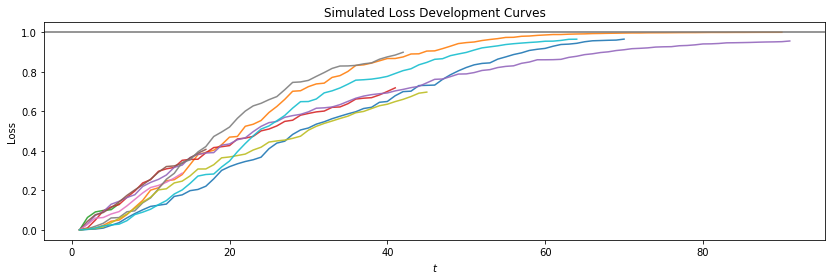

In [134]:
fig, ax = plt.subplots(figsize=(14, 4))

simulator = FraudForcastingDataSimulator(ultimate_loss_mean=1.0, ultimate_loss_std=0.0)

for _ in range(10):
    group = simulator.simulate_one_random_group()
    ax.plot(group['t'], group['y'], alpha=0.9)
    ax.axhline(group['ultimate_loss'][0], color='grey', alpha=0.2)

ax.set_title("Simulated Loss Development Curves")
ax.set_xlabel("$t$")
ax.set_ylabel("Loss")

In [385]:
simulator = FraudForcastingDataSimulator(ultimate_loss_mean=1.0, ultimate_loss_std=0.0)
df = simulator.simulate_multiple_groups(n_groups=20)

In [386]:
df.head()

,ultimate_loss,alpha,beta,t,y,id
0,1.0,36.453913,1.577654,1,0.000000,0
1,1.0,36.453913,1.577654,2,0.000497,0
2,1.0,36.453913,1.577654,3,0.009824,0
3,1.0,36.453913,1.577654,4,0.015999,0
4,1.0,36.453913,1.577654,5,0.027200,0


In [426]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


class WeibullCDFModel:
    
    def __init__(self):
        self.model = None
    
    def fit(self, t: pd.Series, group_id: pd.Series, y: pd.Series):
        working_y = np.log(- np.log(1 - y) + 0.001)
        training_frame = pd.concat([group_id, t, working_y], axis=1)
        self.model = smf.mixedlm(
            "y ~ 1 + np.log(t)", training_frame, re_formula='1 + np.log(t)', groups=training_frame['id']
        )
        self.results = self.model.fit()
        # Caclulate the total effect in each level
        # by summing the fixed effect and the random effect.
        fixed_effects = model.results.fe_params
        fixed_effects.index = ['Group', 'np.log(t)'] 
        self.effects_ = {
            idx: model.results.random_effects[idx] + fixed_effects 
            for idx in model.results.random_effects
        }
        self.parameters_ = {
            idx: pd.Series([
                np.exp(- effect['Group'] / effect['np.log(t)']),
                effect['np.log(t)'],
            ], index=['alpha', 'beta'])
            for idx, effect in self.effects_.items()
        }
    
    def forecast_groups(self, t: pd.Series, group_ids: pd.Series):
        forecasts = []
        unique_group_ids = group_ids.unique()
        for id in unique_group_ids:
            group_ts = t[group_ids == id]
            forecasts.append(self._forecast_group(group_ts, id))
        print(sum(len(x) for x in forecasts))
        return pd.DataFrame({
            'y_hat': np.concatenate(forecasts),
            'id': group_ids
        })
    
    def _forecast_group(self, t: pd.Series, group_id: int):
        parameters = self.parameters_[group_id]
        return weibull_growth_curve(t, 1.0, parameters['alpha'], parameters['beta'])

In [427]:
model = WeibullCDFModel()
model.fit(group_id=df['id'], t=df['t'], y=df['y'])

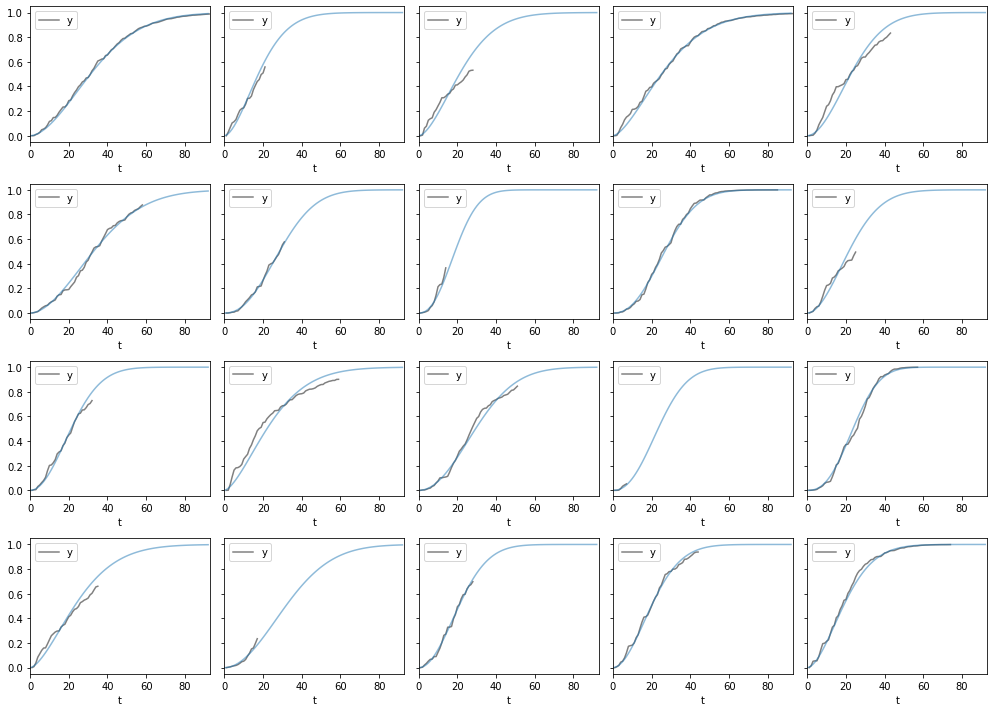

In [396]:
fig, axs = plt.subplots(4, 5, figsize=(14, 10), sharey=True)

ts = np.arange(MATURATION_TIME)

for ax, (idx, parameters) in zip(axs.flatten(), model.parameters_.items()):
    df[df['id'] == idx].plot('t', 'y', ax=ax, label=None, color='grey')
    ys = model._forecast_group(ts, group_id=idx)
    ax.plot(ts, ys, alpha=0.5)
    ax.set_xlim([0, MATURATION_TIME])

fig.tight_layout()

In [433]:
simulator = FraudForcastingDataSimulator(ultimate_loss_mean=100.0, ultimate_loss_std=10.0)
df = simulator.simulate_multiple_groups(n_groups=20)

In [621]:
class FraudForcasingModel:
    
    def __init__(self, initial_ultimate_estimate=200):
        self.initial_ultimate_estimate = initial_ultimate_estimate
        self.weibull_model_ = None
        self.ultimate_losses_ = None
    
    def fit(self, t: pd.Series, group_ids: pd.Series, y: pd.Series):
        y = y.copy()
        groups, n_groups = group_ids.unique(), len(group_ids.unique())
        ultimate_losses = pd.Series(
            np.full(n_groups, self.initial_ultimate_estimate),
            index=groups
        )
        maximum_losses = y.groupby(group_ids).max() + 0.01
        for _ in range(5):
            # These shenannigans are needed beacuse pd.Series does not 
            # have a set_index method :(
            y.index = group_ids
            working_y = y / ultimate_losses
            y = y.reset_index(drop=True)
            working_y = working_y.reset_index(drop=True)
            working_y.name = 'y'
            # Fit a model for the underlying proportion time series
            weibull_model = WeibullCDFModel()
            weibull_model.fit(group_id=group_ids, t=t, y=working_y)
            # Build the series of predicted values from the fit model.
            proportion_forecasts = weibull_model.forecast_groups(t, group_ids).iloc[:, 0]
            #forecasts = (ultimate_losses * proportion_forecasts).reset_index(drop=True)
            # Update the estimates for ultimate losses
            #return proportion_forecasts
#             ultimate_losses =  np.exp(
#                 (np.log(y[y > 0]) - np.log(proportion_forecasts[y > 0])).groupby(group_ids[y > 0]).mean()
#             )
            numerator = (y * proportion_forecasts).groupby(group_ids).sum()
            denominator = (proportion_forecasts**2).groupby(group_ids).sum()
            ultimate_losses = numerator / denominator
            ultimate_losses = pd.concat([ultimate_losses, maximum_losses], axis=1).max(axis=1)
            print(ultimate_losses)

In [622]:
forecast = FraudForcasingModel()

In [623]:
fsts = forecast.fit(group_ids=df['id'], t=df['t'], y=df['y'])

1088
id
0     139.270956
1     118.366525
2     117.183006
3      88.893122
4      78.069319
5     227.984066
6      98.106646
7     100.076532
8     105.114237
9     115.603438
10     82.697431
11    109.123172
12     95.550956
13    103.425708
14     66.516787
15    115.188675
16     90.617498
17     83.066233
18     95.411933
19     79.935439
dtype: float64
1088
id
0     139.270956
1     118.366525
2     117.183006
3      88.893122
4      78.069319
5     227.984066
6      98.106646
7     100.076532
8     105.114237
9     115.603438
10     82.697431
11    109.123172
12     95.550956
13    103.425708
14     66.516787
15    115.188675
16     90.617498
17     83.066233
18     95.411933
19     79.935439
dtype: float64
1088
id
0     139.270956
1     118.366525
2     117.183006
3      88.893122
4      78.069319
5     227.984066
6      98.106646
7     100.076532
8     105.114237
9     115.603438
10     82.697431
11    109.123172
12     95.550956
13    103.425708
14     66.516787
15    115.1

In [624]:
df.groupby('id').max()

,ultimate_loss,alpha,beta,t,y
id,,,,,
0,105.138297,27.890212,2.232671,25,53.708283
1,117.679703,19.338664,1.544767,24,85.836511
2,106.843296,19.571047,1.727912,59,106.688205
3,107.878141,37.486487,1.423381,56,88.671413
4,79.980425,33.607825,1.306921,93,78.059319
5,98.496900,25.772383,1.354916,17,40.183094
6,91.059476,22.751881,1.644404,79,91.013158
7,105.792828,22.853938,1.024004,66,100.066532
8,105.154694,36.216260,2.417267,85,105.104237


In [578]:
fsts

id
0      55.255103
1      94.345870
2     110.419673
3      84.253693
4      81.289354
5     297.310085
6     112.434817
7     113.330758
8      84.366030
9      86.059123
10     76.836842
11     84.515364
12    122.140437
13     65.247106
14     63.040088
15    123.296660
16     47.744382
17     88.389500
18    107.582554
19     79.080913
dtype: float64

In [540]:
np.log(df['y'][df['y'] > 0]) - np.log(fsts[df['y'] > 0])

1      -9.591561
2      -3.234786
3      -2.385916
4      -2.076029
5      -2.187158
          ...   
1083   -0.923456
1084   -0.910419
1085   -0.903321
1086   -0.892232
1087   -0.890671
Length: 1068, dtype: float64

In [538]:
fsts[df['y'] > 0]

1         1.022583
2         2.103526
3         3.503499
4         5.196057
5         7.159336
           ...    
1083    191.218392
1084    192.256988
1085    193.187309
1086    194.018566
1087    194.759478
Length: 1068, dtype: float64

In [531]:
fsts.reset_index()[df['y'] > 0]

,level_0,index,0
1,1,0,1.022583
2,2,0,2.103526
3,3,0,3.503499
4,4,0,5.196057
5,5,0,7.159336
...,...,...,...
1083,1083,19,191.218392
1084,1084,19,192.256988
1085,1085,19,193.187309
1086,1086,19,194.018566
